In [2]:
%matplotlib inline
from utils import *

import tensorflow as tf
import tcn
import keras
from IPython.display import display, clear_output

In [4]:
eps = 1e-12
##########################################################################################################
class DATA(object):    
    # ---------------------------------------------------------------------------------------------------   
    def __init__(self, database_name, records_numbers, target, features):            
        self.X = list()
        self.Y = list()

        for n in records_numbers:
            file_path = get_dataset_file_path(dataset_name, 'record_'+"{0:0=2d}".format(n)) 
            data = pd.read_pickle( file_path )  
            x = data.filter(regex=features, axis=1).values
            y = data.filter(regex=target, axis=1).values
            
            # lists
            self.X.append( x )
            self.Y.append( y.reshape((len(y))) )

        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        return
    # ---------------------------------------------------------------------------------------------------   
    def mtx( self, Nt_mtx='max' ):  
        # This function padds or cuts all input data (X) to make them same length and generate matrix data(X_mtx)
        # it also nomalize data X-mean(X)
        data_mtx = copy.deepcopy(self)
        if len(np.shape(data_mtx.X))>1:  return data_mtx    

        Nt_list = [np.shape(x)[0] for x in self.X]
        Nt = int( eval('np.' + Nt_mtx)(Nt_list) )
        Nd, Nf = len(self.X),  np.shape(self.X[0])[1]
        
        data_mtx.X = np.zeros( (Nd,Nt,Nf) )
        data_mtx.Y = np.zeros( (Nd,Nt) )
        
        for idx, x in enumerate(self.X): 
            nt = np.shape(x)[0]
            
            if Nt >= nt:
                data_mtx.X[idx,:,:] = np.pad( x, ((0,Nt-nt),(0,0)),'constant')
                data_mtx.Y[idx,:nt] = self.Y[idx]
                
            else:
                data_mtx.X[idx,:,:] = x[:Nt,:]
                data_mtx.Y[idx, :] = self.Y[idx][:Nt]
        return data_mtx
    # ---------------------------------------------------------------------------------------------------   
    def bound(self, min_value=None, max_value=None):
        # This function limits the amplitude value 
        
        bounded_data = copy.deepcopy(self)
        if min_value is not None:
            for x in bounded_data.X: x[ x<min_value ] = min_value
        if max_value is not None:                
            for x in bounded_data.X: x[ x>max_value ] = max_value
        
        return bounded_data
    # ---------------------------------------------------------------------------------------------------   
    def trim(self, keep_ratio=None):
        trimmed_data = copy.deepcopy(self)
        trimmed_data.X = list()
        
        if keep_ratio is None:
            dt = 20   
            for x in self.X:     
                N = len(x)
                n1, n2 = dt, N-dt 
                xx = abs( np.diff(x))
                xx = np.sum(xx, axis=1)    
                xx = abs(np.diff(xx))
                xx /= ( np.nanmax(xx) + eps )                 
                idxs = np.where( xx > 0.5 )[0]    
                idxs1 = idxs[idxs < 0.5*N] 
                idxs2 = idxs[idxs > 0.5*N]      
                if np.any(idxs1): n1 = np.min(idxs1) + dt
                if np.any(idxs2): n2 = np.max(idxs2) - dt   
                if (n2-n1) < 0.5*N: n1, n2 = 0, N            
                trimmed_data.X.append( x[n1:n2,:] )
        else:   
            for x in self.X:
                L = int( len(x) * keep_ratio)
                trimmed_data.X.append( x[:L,:] ) 

        trimmed_data.X = np.array(trimmed_data.X)    
        return trimmed_data    
    # ---------------------------------------------------------------------------------------------------      
    def quantize(self, Qstep):        
        quantized_data = copy.deepcopy(self)
        for idx, x in enumerate(quantized_data.X): 
            quantized_data.X[idx] = Qstep * np.floor(x/Qstep)
        return quantized_data   
    # ---------------------------------------------------------------------------------------------------   
    def clean(self):
        # cleans data from NANs ! 
        cleaned_data = copy.deepcopy(self)
        for idx, x in enumerate(cleaned_data.X):
            if np.any(np.isnan(x)):
                df = pd.DataFrame(x)
                df.fillna(method='ffill', axis=0, inplace=True)
                cleaned_data.X[idx] = df.as_matrix()
                
        return cleaned_data                
    # ---------------------------------------------------------------------------------------------------   
    def filter_noise(self, window_length=5, polyorder=2):
        filtered_data = copy.deepcopy(self)
        for n, x in enumerate(self.X):
            for i in range(8):
                filtered_data.X[n][:,i] = signal.savgol_filter(x[:,i], window_length, polyorder)        
        return filtered_data
    # ---------------------------------------------------------------------------------------------------   
    def MinMax(self):
        # Rescale data value to (0,1)
        normalized_data = copy.deepcopy(self)
        for idx, x in enumerate(normalized_data.X): 
            MIN = np.nanmin(x,axis=0)
            MAX = np.nanmax(x,axis=0)
            normalized_data.X[idx] = np.subtract(x,MIN) / ( np.subtract(MAX,MIN) + eps )
        return normalized_data    
    # ---------------------------------------------------------------------------------------------------    
    def standardize(self, scale=True):
        normalized_data = copy.deepcopy(self)
        STD = 1
        for idx, x in enumerate(normalized_data.X): 
            MEAN = np.mean(x,axis=0)
            if scale: STD = np.std(x,axis=0) + eps
            normalized_data.X[idx] = np.subtract(x,MEAN) / STD    
        return normalized_data         

In [24]:
dataset_name = 'dataset_02' 
target = 'distance_1' 
features = 'rssi'
Nt_mtx = 'median'

train_data = DATA(dataset_name, np.arange(25), target, features)
train_data = train_data.standardize()
train_data = train_data.mtx(Nt_mtx=Nt_mtx)

validation_data = DATA(dataset_name, np.arange(25,30), target, features)
validation_data = validation_data.standardize()
validation_data = validation_data.mtx(Nt_mtx=Nt_mtx)

print( "Train Data - X: \t", np.shape(train_data.X))
print( "Train Data - Y: \t", np.shape(train_data.Y))
print( "Validation Data - X: \t", np.shape(validation_data.X))
print( "Validation Data - Y: \t", np.shape(validation_data.Y))

Train Data - X: 	 (25, 476, 2)
Train Data - Y: 	 (25, 476)
Validation Data - X: 	 (5, 646, 2)
Validation Data - Y: 	 (5, 646)


In [6]:
class REGRESSOR(object):
    
    def __init__(self, win_size, step=1, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.step = step                
        self.build_model(**params)
        
    
    def train(self, train_data, epochs=30, verbose=0, show=True):        
        loss = list()        
        for n_epoch in range(epochs):
            display(n_epoch+1)
            
            ep_loss = list()            
            for i in range(0, np.shape(train_data.X)[1]-self.win_size, self.step):
                history = self.model.fit( 
                    train_data.X[:, i:i+self.win_size,:], 
                    train_data.Y[:, i+self.win_size-1], 
                    epochs = 1, 
                    verbose = verbose
                )    
                ep_loss.append(history.history['loss'])
            
            loss.append(ep_loss)
            clear_output(wait=True)
        loss = np.array(loss)
        
        if show:
            plt.plot( np.ndarray.flatten(loss) )
            plt.show()
        return loss

    
    def predict(self, X):
        predictions = list()
        for i in range(0, np.shape(X)[1]-self.win_size, self.step):
            pred = self.model.predict( X[:, i:i+self.win_size,:])
            predictions.append(pred)
        
        predictions = np.array(predictions)
        return predictions.reshape((-1, np.shape(predictions)[1])).transpose()  
    
    
# ------------------------------------------   
class RNN(REGRESSOR):
    def build_model(self, Nunits=5, Nlayers=2, Nfeatures=2, activation='tanh', optimizer='adam', loss='mse'):
        self.model = keras.models.Sequential()   
        
        if Nlayers>1:
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=True, input_shape=(self.win_size, Nfeatures)))        
            for n in range(Nlayers-2): 
                self.model.add( keras.layers.LSTM(Nunits, return_sequences=True))  
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=False))   
        else:
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=False, input_shape=(self.win_size, Nfeatures)))        

        self.model.add( keras.layers.Dense(1, activation=activation))  
        
        self.model.compile(loss=loss, optimizer=optimizer) 
        
        print(self.model.summary())        
        return 

    
# ------------------------------------------   
class TCN(REGRESSOR):
    def build_model(self, Nlayers=2, nb_filters=5, Nfeatures=2, activation=None, optimizer='adam', loss='mse' ):  
        i = tf.keras.Input(batch_shape=(None, self.win_size, Nfeatures)) 
        if Nlayers>1:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=True)(i)
            for n in range(Nlayers-2): tcn.TCN(nb_filters=nb_filters, return_sequences=True)(o)    
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(o)
        else:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(i)     
            
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])
        
        self.model.compile(loss=loss, optimizer=optimizer)
        
        print(self.model.summary())                
        return 

# TCN

#### Build Model

In [7]:
regressor = TCN(
    win_size = 20,
    step = 1,
    Nlayers = 2,
    nb_filters=64,
    activation = None, 
    optimizer = 'adam', 
    loss = 'mse',
    Nfeatures = 2    
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 2)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 20, 64)            91328     
_________________________________________________________________
tcn_1 (TCN)                  (None, 64)                99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 190,465
Trainable params: 190,465
Non-trainable params: 0
_________________________________________________________________
None


#### Training

In [9]:
loss = regressor.train( train_data, epochs=30 )

#### Validation

In [ ]:
idx = 2
data = train_data
x, y = data.X[idx], data.Y[idx]
x = np.reshape(x, (1, np.shape(x)[0], np.shape(x)[1]))
y = np.reshape(y, (1, np.shape(y)[0]))

predictions = regressor.predict(x)

print(np.shape(y))
print(np.shape(predictions))

plt.plot(y[0,regressor.win_size:])
plt.plot(predictions[0])
plt.show()

# RNN

#### Build Model

In [29]:
regressor = RNN(
    win_size=30,
    step=1,
    Nlayers = 1,
    Nunits = 1, 
    activation = None, 
    optimizer = 'adam', 
    loss = 'mse',
    Nfeatures = 2 
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1)                 16        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
None


#### Training

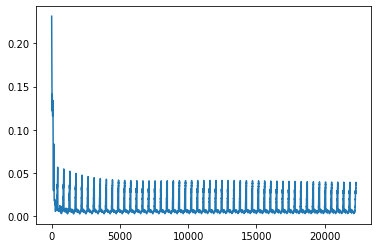

In [30]:
loss = regressor.train( train_data, epochs=50 )

#### Validation

(1, 476)
(1, 446)


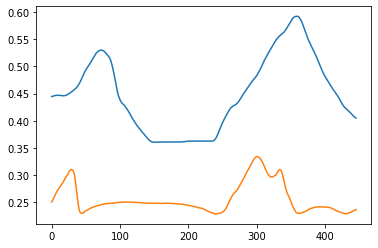

In [34]:
idx = 2
data = train_data
x, y = data.X[idx], data.Y[idx]
x = np.reshape(x, (1, np.shape(x)[0], np.shape(x)[1]))
y = np.reshape(y, (1, np.shape(y)[0]))

predictions = regressor.predict(x)

print(np.shape(y))
print(np.shape(predictions))

plt.plot(y[0,regressor.win_size:])
plt.plot(predictions[0])
plt.show()